## Set Up and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Dataset From UCI Machine Learning Repository

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car_evaluation.data.features
y = car_evaluation.data.targets

# metadata
print(car_evaluation.metadata)

# variable information
print(car_evaluation.variables)


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'ID': 249, 'type': 'NATIVE', 'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'venue': '8th Intl Workshop on Expert Systems and their Applications, 

In [ ]:
# combine features and targets into one dataframe
df = pd.concat([X, y], axis=1)

### EDA


In [ ]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [ ]:
!pip -q install ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(
df,
title="Car Evaluation EDA", #Name your EDA output here
explorative=True,
minimal=False
)

profile.to_file("car_data_eda1.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 17.20it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from google.colab import files

files.download("car_data_eda1.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Source - https://stackoverflow.com/a/55329863
# Posted by Tal
# Retrieved 2026-02-18, License - CC BY-SA 4.0

import IPython
IPython.display.HTML(filename="/content/car_data_eda1.html")


Text(0.5, 1.0, 'Distribution of Class')

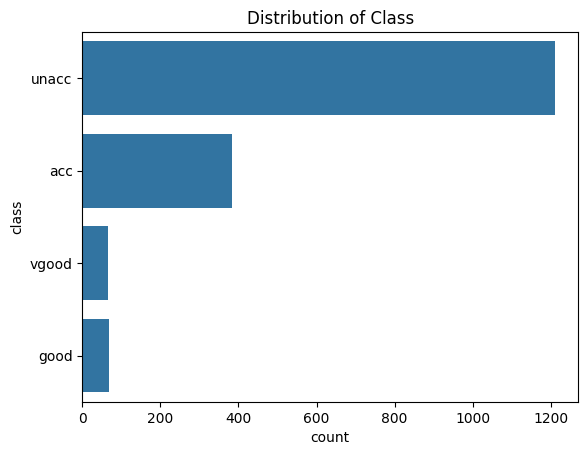

In [ ]:
sns.countplot(df['class'])
plt.title('Distribution of Class')

The target variable (class) is unbalanced, so we will need to address this in our model. The target variable is mainly correlated with safety and persons.

### Preprocessing

In [ ]:
# Drop duplicates
df = df.drop_duplicates()

In [ ]:
# Check for null values
print(df.isnull().sum())

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


In [ ]:
# Encode categorical variables manually to avoid incorrect ordering
buying_order = {'low' : 0, 'med' : 1, 'high' : 2, 'vhigh' : 3}
df['buying'] = df['buying'].map(buying_order)

maint_order = {'low' : 0, 'med' : 1, 'high' : 2, 'vhigh' : 3}
df['maint'] = df['maint'].map(maint_order)

doors_order = {'2' : 0, '3' : 1, '4' : 2, '5more' : 3}
df['doors'] = df['doors'].map(doors_order)

persons_order = {'2' : 0, '4' : 1, 'more' : 2}
df['persons'] = df['persons'].map(persons_order)

lug_boot_order = {'small' : 0, 'med' : 1, 'big' : 2}
df['lug_boot'] = df['lug_boot'].map(lug_boot_order)

safety_order = {'low' : 0, 'med' : 1, 'high' : 2}
df['safety'] = df['safety'].map(safety_order)

class_order = {'unacc' : 0, 'acc' : 1, 'good' : 2, 'vgood' : 3}
df['class'] = df['class'].map(class_order)

# Check DataFrame is properly encoded
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,0,0,0
1,3,3,0,0,0,1,0
2,3,3,0,0,0,2,0
3,3,3,0,0,1,0,0
4,3,3,0,0,1,1,0


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target
X = df.drop('class', axis = 1)
y = df['class']

# Splitting data into train and test sets
# Making sure to stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

## Entropy Model Implementation and Evaluation

The goal for this model is to predict the class of a car based on given features.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Instantiate the model
dt = DecisionTreeClassifier(criterion = 'entropy', class_weight= 'balanced', random_state = 42)

# Fit the model
dt.fit(X_train, y_train)

# Predict results using test data
y_e_dt_pred = dt.predict(X_test)

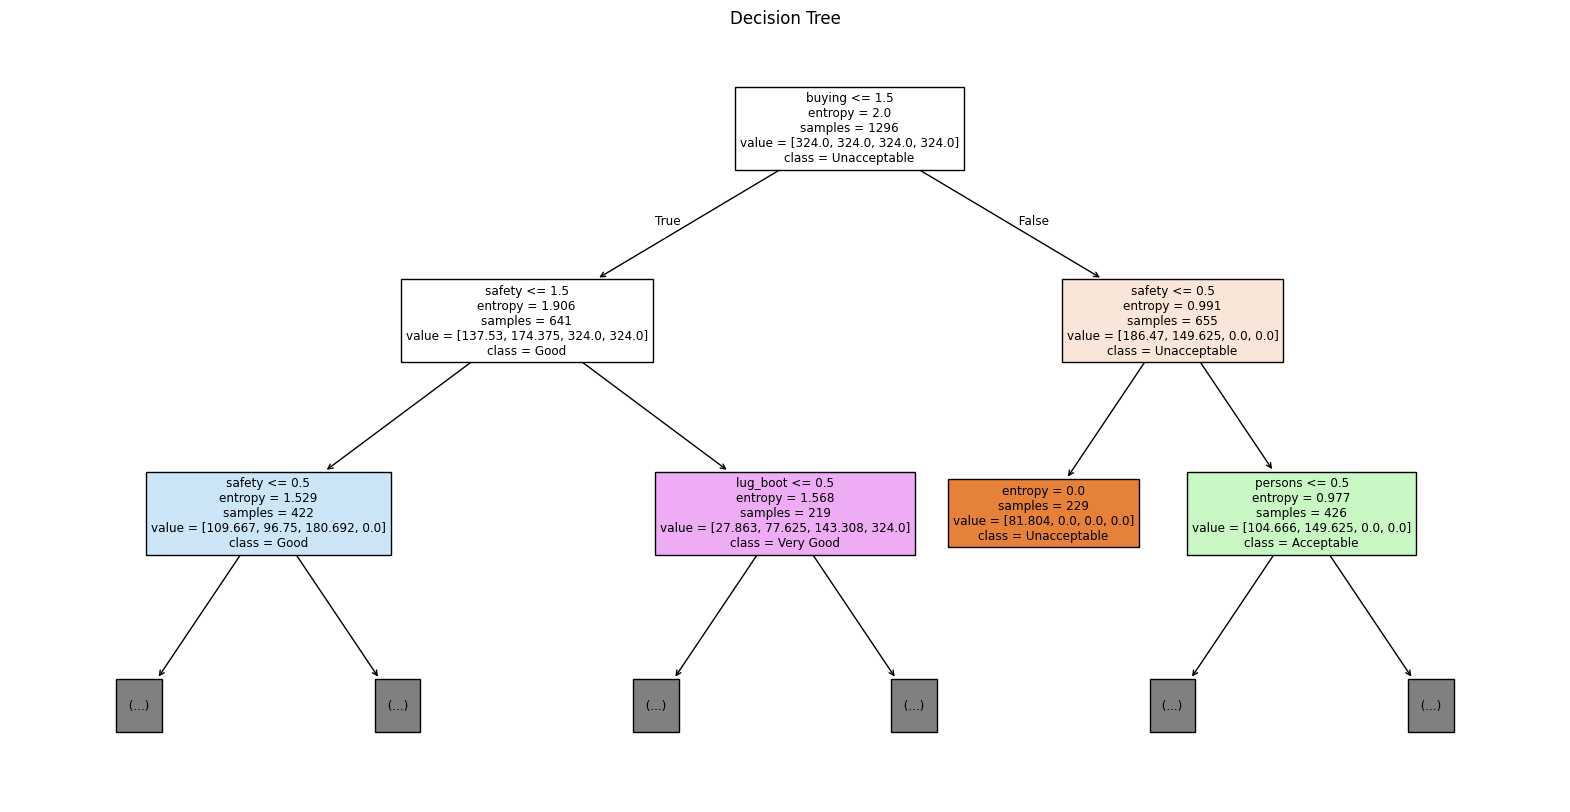

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize = (20, 10))
plot_tree(
dt,
filled=True,
feature_names = X_train.columns,
class_names = ['Unacceptable', 'Acceptable', 'Good', 'Very Good'],
max_depth = 2
)
plt.title("Decision Tree")
plt.show()

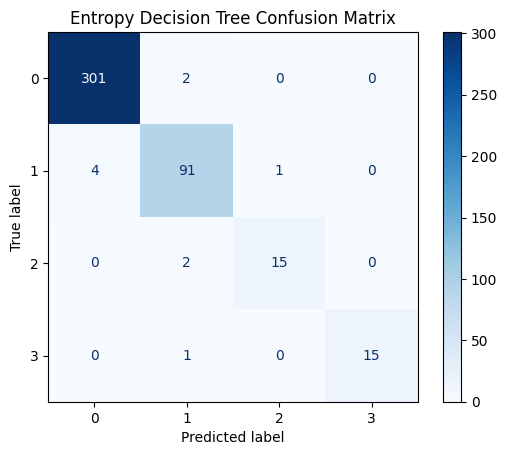

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_e_dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title('Entropy Decision Tree Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_e_dt_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       303
           1       0.95      0.95      0.95        96
           2       0.94      0.88      0.91        17
           3       1.00      0.94      0.97        16

    accuracy                           0.98       432
   macro avg       0.97      0.94      0.95       432
weighted avg       0.98      0.98      0.98       432



### Analyzing Our Results

In [ ]:
baseline_accuracy = df['class'].value_counts(normalize = True).max()

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

Baseline Accuracy: 70.02%


The accuracy of this model is well above the baseline accuracy for this dataset. The precision and recall are both high and balanced. This could show overfitting to the dataset as a whole. I don't have any other data to validate this. The confusion matrix shows that there are 10 incorrect predictions. That is 0.58% of the data.

## Gini Model Implementation and Evaluation

The goal of this model is to predict the class of a car based on given features.

In [ ]:
# Instantiate the model
dt_gini = DecisionTreeClassifier(criterion = 'gini', class_weight= 'balanced', random_state = 42)

# Fit the model
dt_gini.fit(X_train, y_train)

# Predict results using test data
y_dt_gini_pred = dt_gini.predict(X_test)

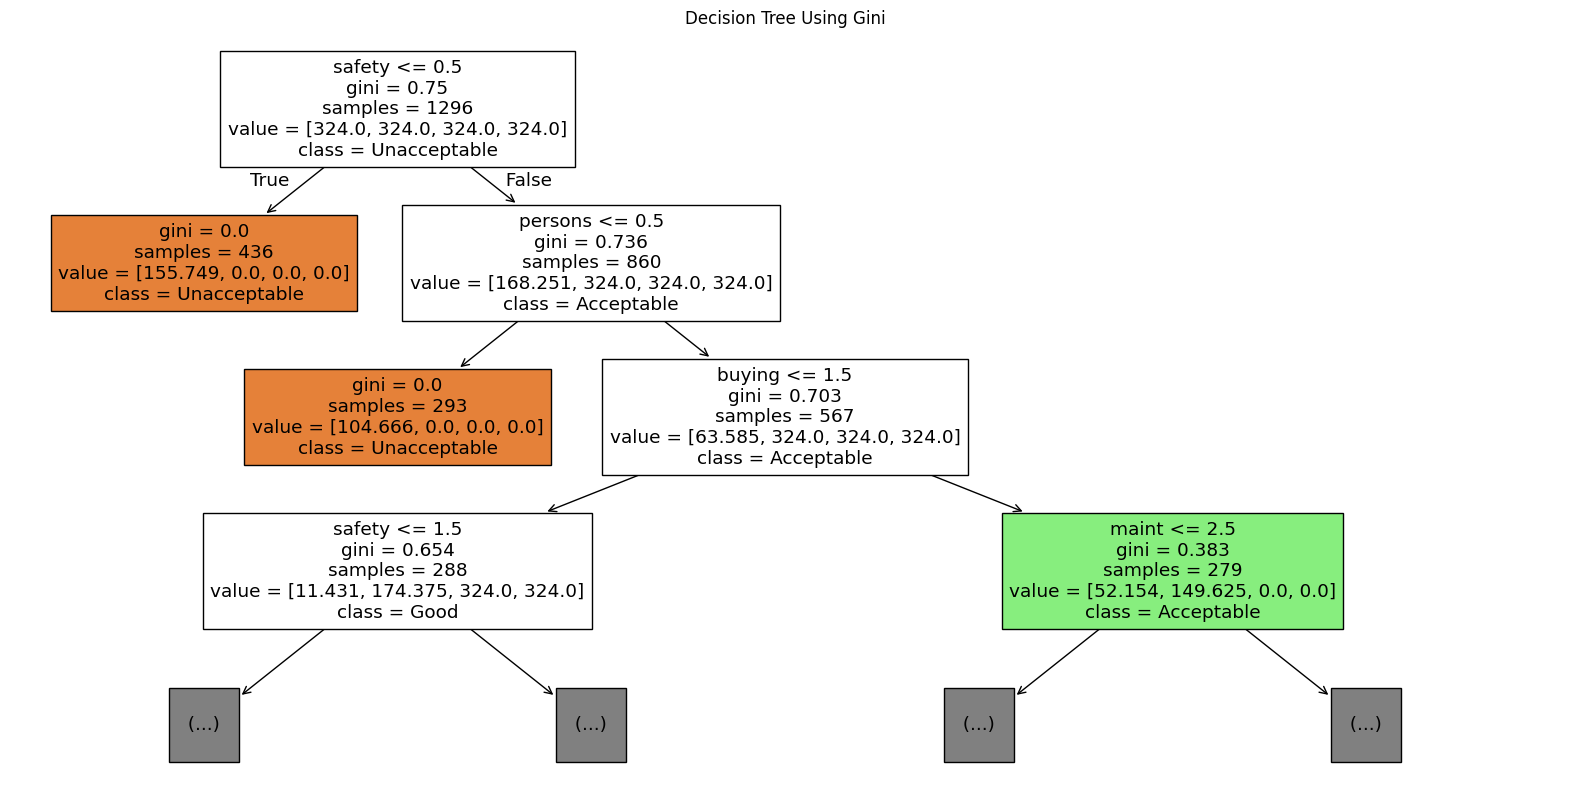

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize = (20, 10))
plot_tree(
dt_gini,
filled=True,
feature_names = X_train.columns,
class_names = ['Unacceptable', 'Acceptable', 'Good', 'Very Good'],
max_depth = 3
)
plt.title("Decision Tree Using Gini")
plt.show()

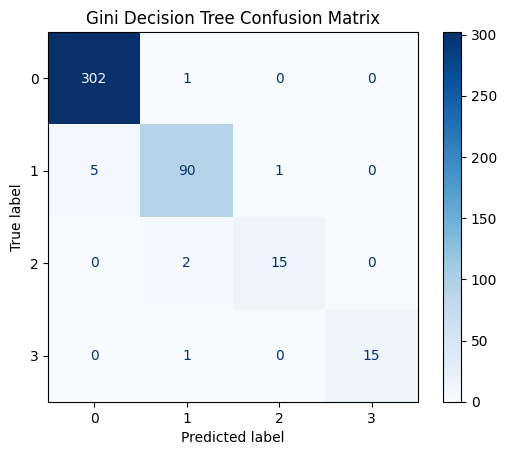

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_dt_gini_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title('Gini Decision Tree Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_dt_gini_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       303
           1       0.96      0.94      0.95        96
           2       0.94      0.88      0.91        17
           3       1.00      0.94      0.97        16

    accuracy                           0.98       432
   macro avg       0.97      0.94      0.95       432
weighted avg       0.98      0.98      0.98       432



### Analyzing Our Results

In [ ]:
baseline_accuracy = df['class'].value_counts(normalize = True).max()

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

Baseline Accuracy: 70.02%


These results are practically identical to the entropy model. There is no significant advantage to using this model except computational efficiency.

## Random Forest Model Implementation and Evaluation

This will train multiple decision trees and address any overfitting.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
classifier = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=42)

# Fit the model
classifier.fit(X_train, y_train)

# Predict results using test data
y_rand_pred = classifier.predict(X_test)

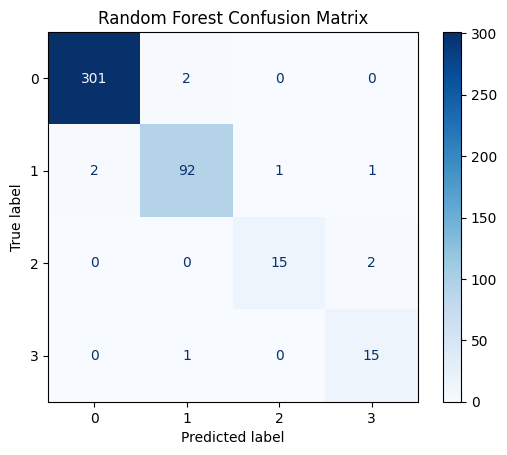

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_rand_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_rand_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       303
           1       0.97      0.96      0.96        96
           2       0.94      0.88      0.91        17
           3       0.83      0.94      0.88        16

    accuracy                           0.98       432
   macro avg       0.93      0.94      0.94       432
weighted avg       0.98      0.98      0.98       432



### Analyzing Our Results

The Random Forest model was slightly better than the decision tree models. The incorect predictions are spread between different labels. This results in a higher probablity to correctly predict off of any given data. It incorrectly predicted 0.52% of the labels.

## Conclusion

The Random Forest model is the best for this dataset. It is able to correctly predict more labels than either of the Decision Tree models.